## Infix to postfix notation
Katia Gramaccini - katia.gramaccini@studio.unibo.it

### Building the expression generator (from provided code)

We start by importing base libraries.

In [ ]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import gdown
file_id = '1SQDAe68aTAoCS0Pdz720cz_vFGoLa1Cw'
output_path = 'modelweights.weights.h5'
gdown.download(id=file_id, output=output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1SQDAe68aTAoCS0Pdz720cz_vFGoLa1Cw
To: /content/modelweights.weights.h5
100%|██████████| 2.84M/2.84M [00:00<00:00, 88.7MB/s]


'modelweights.weights.h5'

In [ ]:
!ls /content/

modelweights.weights.h5  sample_data


We take the vocabulary definition and the expression generator from the provided code.

In [ ]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [ ]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(max_depth)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

### Choosing the architecture

To solve the task, we choose the Transformer architecture, the actual State-of-Art for text generation. We choose this architecture because, in our case, to understand correctly the meaning of the provided infix expression, due to operator precedence rules and parentheses, it is important to focus on the whole sequence: this is exactly how the Attention mechanism operates.\
In particular, the Multi Head attention blocks allow the model to look at different aspects of the sequence, while the Positional Encoding blocks allow to encode information about the relative position of a character in the sequence.

For this sequence-to-sequence task, the optimal architecture should also be Encoder-Decoder, so we rule out a Decoder-only model. The Encoder processes the input sequence to generate a "context" vector, which contains the most meaningful features of the input. Then, this context vector is passed to the Decoder and used for generating the output sequence.

We're going to follow the structure outlined in the paper ["Attention is All You Need"](https://arxiv.org/pdf/1706.03762), by Vaswani et al.

### Building the Transformer architecture

We import the Keras layers that will be used by our model.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add, Layer
from tensorflow.keras.models import Model

# Setting the dropout rate for every layer
DROPOUT_RATE = 0.1

First we define the sinusoidal Positional Encoding layer. The functions that will be used are the following:
$PE_{(pos, 2i)} = \sin ( \frac{pos}{10000^{\frac{2i}{d_{model}}}} )$, $PE_{(pos, 2i+1)} = \cos ( \frac{pos}{10000^{\frac{2i+1}{d_{model}}}} )$, where $PE$ is the positional encoding matrix we want to define, $d_{model}$ is the embedding dimension, $pos \in [0, \text{maxlength}]$ is the position of the character and $i \in [0, d_{model}]$ is the encoding dimension.

In [ ]:
class PositionalEncoder(Layer):
    def __init__(self, max_enc_pos, d_model):
        super().__init__()
        self.d_model = d_model
        self.encode_pos = max_enc_pos
        self.pe_matrix = self.get_pos_enc(max_enc_pos, d_model)

    def get_pos_enc(self, pos, dim):
        #initialize matrix
        pe = np.zeros(shape=(pos, dim))
        #initialize positions vector
        positions = np.arange(0, pos)[:, None]
        #initialize dimensions vector
        i = np.arange(0, dim/2)
        div_term = 1/(10000**(2*i/dim))[None,:]
        #compute matrix
        pe[:, 0::2] = np.sin(positions*div_term)
        pe[:, 1::2] = np.cos(positions*div_term)
        return tf.constant(pe[None, ...], dtype=tf.float32)

    def call(self, inputs):
        #for dynamic shapes (during autoregressive decoding loop)
        seq_len = tf.shape(inputs)[1]
        sliced_pe_matrix = self.pe_matrix[:, :seq_len, :]
        return inputs + sliced_pe_matrix


    def compute_output_shape(self, input_shape):
        return tf.TensorShape((input_shape[0], input_shape[1], self.d_model))


Then we create the basic attention layer that will be used to define all the different attention layers in the architecture. Here we define the class methods used to build the necessary layers.

In [ ]:
class BaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layer_norm = LayerNormalization()
    self.add = Add()

We define the `MultiHeadSelfAttention` block for the encoding. Note that the output of the multi-head attention layer is added to the input of the layer itself: this is actually called *residual connection*. The result is then normalized.

It is a Self-Attention layer because the input for the query, key and value heads is the same (`x`). Also, the MultiHeadAttention layer already does a dropout by itself so we don't add another Dropout layer ([MultiHeadAttention docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)).

In [ ]:
class MultiHeadSelfAttention(BaseAttention):
  def call(self, x, training=False):
    attention_output = self.mha(query=x, key=x, value=x, training=training)
    x = self.add([x, attention_output])
    x = self.layer_norm(x)
    return x

Then we define the `FeedForward` layer, which is basically a fully connected network made of two Dense layer with a ReLU activation in the middle, followed by a Dropout layer. We also add a residual connection followed by a layer normalization. The first Dense layer expands the model dimension (from $d_{model}$ to $\text{dff}$), then the ReLU activation is applied and then the second Dense layer returns the model to its original dimension (from $\text{dff}$ to $d_{model}$).

In [ ]:
class FeedForward(Layer):
  def __init__(self, d_model, dff, dropout_rate=DROPOUT_RATE):
    super().__init__()
    self.dense1 = Dense(dff, activation='relu')
    self.dense2 = Dense(d_model)
    self.dropout = Dropout(dropout_rate)
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x, training=False):
    x_ff = self.dense1(x)
    x_ff = self.dense2(x_ff)
    x_ff = self.dropout(x_ff, training=training)
    x = self.add([x, x_ff])
    x = self.layer_norm(x)
    return x

We can now define the `EncoderLayer`, a block made of:
- a `MultiHeadSelfAttention` block
- a `FeedForward` layer

In [ ]:
class EncoderLayer(Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=DROPOUT_RATE):
    super().__init__()
    self.d_model = d_model

    self.self_attention = MultiHeadSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, training=False):
    x = self.self_attention(x, training=training)
    x = self.ffn(x, training=training)
    return x

  def compute_output_shape(self, input_shape):
    return tf.TensorShape((input_shape[0], input_shape[1], self.d_model))

Finally, we can define the `Encoder`, which is made of different blocks:
- an Embedding layer (whose result is multiplied by $\sqrt{d_{model}}$ to stabilize the result as seen in Vaswani et al.)
- a Dropout layer
- `num_layers` `EncoderLayer`

In [ ]:
class Encoder(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, \
                 maximum_position_encoding, dropout_rate=DROPOUT_RATE):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoder(maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)
        self.encoder_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                        for _ in range(num_layers)]

    def call(self, x, training=False):
        # Embedding layer
        x = self.embedding(x)
        # to stabilize (as in Vaswani et al.)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encoding layer
        x = self.pos_encoding(x)
        # Add Dropout layer (as in Vaswani et al.)
        x = self.dropout(x, training=training)
        # Encoder core: num_layers encoder layers
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training=training)
        return x

    def compute_output_shape(self, input_shape):
        return tf.TensorShape((input_shape[0], input_shape[1], self.d_model))

We define the `MaskedMultiHeadSelfAttention` layer using the `BaseAttention` one. It is a self-attention layer, so the input for the query, key, and value heads is the same. This is a *masked* layer because we use a causal mask to prevent the attention mechanism from looking at future tokens to predict the current one (so we set `use_causal_mask=True`). Finally we add a residual connection and a layer normalization this time as well.

In [ ]:
class MaskedMultiHeadSelfAttention(BaseAttention):
  def call(self, x, training=False):
    attention_output = self.mha(query=x, key=x, value=x, use_causal_mask = True, training=training)
    x = self.add([x, attention_output])
    x = self.layer_norm(x)
    return x

Now we define the `CrossAttention` layer. Here, we don't have a self attention mechanism anymore, since the input for the query head has to come from the decoder input, while for the key and the value one (the "context") it has to come from the encoder output. Like the others, it includes a residual connection and a layer normalization.

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context, training=False):
    attention_output = self.mha(query=x, key=context, value=context, training=training)
    x = self.add([x, attention_output])
    x = self.layer_norm(x)
    return x

With these blocks, we can now build the `DecoderLayer`, made of:
- a `MaskedMultiHeadSelfAttention` (called "Casual") layer
- a `CrossAttention` layer
- a `FeedForward` layer

In [ ]:
class DecoderLayer(Layer):
  def __init__(self,*,d_model,num_heads,dff,dropout_rate=DROPOUT_RATE):
    super().__init__()
    self.causal_self_attention = MaskedMultiHeadSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,key_dim=d_model,dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)
    self.d_model = d_model

  def call(self, x, context, training=False):
    x = self.causal_self_attention(x=x, training=training)
    x = self.cross_attention(x=x, context=context, training=training)
    x = self.ffn(x, training=training)
    return x

  def compute_output_shape(self, input_shape):
    return tf.TensorShape((input_shape[0], input_shape[1], self.d_model))

Finally we can also define the `Decoder` structure, made of:
- an Embedding layer (multiplied by $\sqrt{d_{model}}$)
- a Dropout layer
- `num_layers` `DecoderLayer`

In [ ]:
class Decoder(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, \
                 maximum_position_encoding, dropout_rate=DROPOUT_RATE):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoder(maximum_position_encoding, d_model)
        self.dropout = Dropout(dropout_rate)
        self.decoder_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
                        for i in range(num_layers)]

    def call(self, x, encoder_output, training=False):
        # Embedding layer
        x = self.embedding(x)
        # to stabilize (as in Vaswani et al.)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # Positional encoding layer
        x = self.pos_encoding(x)
        # Dropout layer (as in Vaswani et al.)
        x = self.dropout(x, training=training)
        # Decoder core: num_layers layers
        for i in range(self.num_layers):
            x = self.decoder_layers[i](x, encoder_output, training=training)
        return x

    def compute_output_shape(self, input_shape):
        return tf.TensorShape((input_shape[0], input_shape[1], self.d_model))

At last, we define the `Transformer` model, made of:
- an `Encoder` block
- a `Decoder` block
- a Dense linear layer

To improve numerical stability, we don't add a final Softmax layer but when we will instantiate `SparseCategoricalCrossEntropy` we will add the parameter `from_logits=True` (because the model is going to output logits).

In [ ]:
class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,\
                 maximum_position_encoding, dropout_rate=DROPOUT_RATE):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, dropout_rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, dropout_rate)
        self.final_layer1 = Dense(input_vocab_size)

    def call(self, inputs, training=False):
        context, x  = inputs
        encoder_output = self.encoder(context, training=training)
        decoder_output = self.decoder(x, encoder_output, training=training)
        outputs = self.final_layer1(decoder_output)
        return outputs

### Choosing the hyperparameters and instantiating the model

We set the hyperparameters and instantiate the `Transformer` model.

We tried different combinations of hyperparameters and the following one gives the best results.

In [ ]:
EMBED_DIM = 32
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = NUM_ENC_LAYERS
D_FF = 4*MAX_LEN #128
NUM_HEADS = 4
BATCH_SIZE = 8
EPOCHS = 50
#DROPOUT_RATE = 0.1

In [ ]:
transformer = Transformer(num_layers=NUM_ENC_LAYERS, d_model=EMBED_DIM, num_heads=NUM_HEADS, dff=D_FF,\
                           input_vocab_size=VOCAB_SIZE, maximum_position_encoding=MAX_LEN)

We then define the input shapes to get a preview of the model.

In [ ]:
encoder_input = Input(shape=(MAX_LEN,))
decoder_input = Input(shape=(MAX_LEN,))
outputs = transformer([encoder_input, decoder_input])

In [ ]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ (None, 30, 32)         │        74,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ (None, 30, 32)         │       125,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30, 15)         │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,607 (783.62 KB)

 Trainable params: 200,607 (783.62 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling and fitting the model

Before training, we now have to define the necessary functions, meaning loss, optimizer, accuracy metrics and callbacks.

In [ ]:
# LR schedule
WARMUP_STEPS = 4000
# Adam optimizer
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 1e-09
# Early stopping
MIN_DELTA = 0.005
PATIENCE= 15

We use the `SparseCategoricalCrossentropy` loss because the input is not one-hot encoded and there are multiple output classes. To add numerical stability we set the parameter `from_logits=True`. Also, since we want the model to ignore the eventual padding, we set `ignore_class=PAD_ID`.

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = SparseCategoricalCrossentropy(from_logits=True, ignore_class=PAD_ID)

Now we have to define the optimizer: we implement `Adam` but with the same custom Learning Rate schedule implemented in Vaswani et. al, which is equal to
$lr = d_{model}^{-0.5} \cdot min(step^{-0.5}, step \cdot \text{warmupsteps}^{-1.5})$. We also use the same parameters as the ones presented in the paper.

In [ ]:
class LRschedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model=EMBED_DIM, warmupsteps=WARMUP_STEPS):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmupsteps = tf.cast(warmupsteps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        lr =tf.math.rsqrt(self.d_model) * tf.math.minimum(tf.math.rsqrt(step), step*tf.math.pow(self.warmupsteps,-1.5))
        return tf.reshape(lr, [])

In [ ]:
from tensorflow.keras.optimizers import Adam
lrschedule=LRschedule()
optimizer = Adam(learning_rate=lrschedule, beta_1 = BETA_1, beta_2=BETA_2, epsilon=EPSILON)

We also define a custom metric called `prefix_accuracy` that will measure the ratio of the length of the correct predicted expression and the length of the total one.

In [ ]:
def prefix_accuracy(y_true, y_pred_id, pad_id=PAD_ID, eos_id=EOS_ID, sos_id=SOS_ID):
    #y_pred_id is a logit, i want integer ids
    y_pred = tf.argmax(y_pred_id, axis=2, output_type=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.int32)

    # check if equal
    match = tf.cast(tf.equal(y_true, y_pred), tf.int32)

    # ignore SOS/PAD tokens
    sos_mask = tf.cast(tf.not_equal(y_true, sos_id), tf.int32)
    match *= sos_mask
    pad_mask = tf.cast(tf.not_equal(y_true, pad_id), tf.int32)
    match *= pad_mask

    # stop match at EOS
    eos_mask =tf.cast(tf.not_equal(y_true, eos_id), tf.int32)
    eos_mask = tf.math.cumprod(eos_mask, axis=1)
    match *= eos_mask

    # stop at first mismatch
    match = tf.math.cumprod(match, axis=1)

    #get prefix and sequence (no pad/eos) valid lengths
    prefix_lengths = tf.cast(tf.reduce_sum(match, axis=1), tf.float32)
    seq_mask = pad_mask * eos_mask
    seq_len = tf.cast(tf.reduce_sum(seq_mask, axis=1), tf.float32)

    # compute the ratio
    scores = tf.where(seq_len>0, prefix_lengths/seq_len, 0.0)
    # compute the average score over sentences
    avg_score = tf.reduce_mean(scores)

    return avg_score


Now we define the `EarlyStopping` callback, and we make it monitor the custom accuracy metric we defined.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping=EarlyStopping(monitor='val_prefix_accuracy', min_delta=MIN_DELTA, patience=PATIENCE, verbose=1, mode='max', restore_best_weights=True)

We summarize the parameters setting here:

In [ ]:
print("Loss: SparseCategoricalCrossentropy")
print("Optimizer: Adam")
print(" Parameters:")
print(" - Learning Rate: Custom schedule")
print("    - Warmup steps: ", WARMUP_STEPS)
print(" - Beta_1: ", BETA_1)
print(" - Beta_2: ", BETA_2)
print(" - epsilon: ", EPSILON)
print("Early Stopping: on validation prefix_accuracy")
print(" Parameters:")
print(" - Min_delta: ", MIN_DELTA)
print(" - Patience: ", PATIENCE)

Loss: SparseCategoricalCrossentropy
Optimizer: Adam
 Parameters:
 - Learning Rate: Custom schedule
    - Warmup steps:  4000
 - Beta_1:  0.9
 - Beta_2:  0.98
 - epsilon:  1e-09
Early Stopping: on validation prefix_accuracy
 Parameters:
 - Min_delta:  0.005
 - Patience:  15


We generate the training and the validation dataset, and for both we compute the corresponding decoder input (that is made of the target sequences shifted once to the right),

In [ ]:
#Training datasets
X_train, Y_train = generate_dataset(10000)
decoder_input_train = shift_right(Y_train)

#Validation datasets
X_val, Y_val = generate_dataset(1000)
decoder_input_val = shift_right(Y_val)

At last, we compile and fit the model to the training data, while also doing validation.

In [ ]:
transformer.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', prefix_accuracy])

In [ ]:
hist = transformer.fit((X_train, decoder_input_train), Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, callbacks=[earlystopping], validation_data=((X_val, decoder_input_val), Y_val))

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 57s 15ms/step - accuracy: 0.0550 - loss: 2.1598 - prefix_accuracy: 0.1014 - val_accuracy: 0.1894 - val_loss: 0.4596 - val_prefix_accuracy: 0.7621
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.1811 - loss: 0.5279 - prefix_accuracy: 0.7247 - val_accuracy: 0.2121 - val_loss: 0.1788 - val_prefix_accuracy: 0.9219
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.2038 - loss: 0.2662 - prefix_accuracy: 0.8646 - val_accuracy: 0.2157 - val_loss: 0.1410 - val_prefix_accuracy: 0.9402
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.2055 - loss: 0.2278 - prefix_accuracy: 0.8884 - val_accuracy: 0.2233 - val_loss: 0.0522 - val_prefix_accuracy: 0.9833
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.2135 - loss: 0.1442 - prefix_accuracy: 0.9226 - val_accuracy: 0.2255 - val_loss: 0.0253 - val_prefix_accuracy: 0.9912
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - ac

After training the model we can see that even though we set the maximum number of epochs to 50, the fitting process ends sooner than we thought: this is due to the early stopping on the validation prefix accuracy.

Now we save the weights of the fitted model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transformer.save_weights('drive/MyDrive/modelweights.weights.h5')

We want to visualize how the model performed during fitting, to see if there are any signs of overfitting.

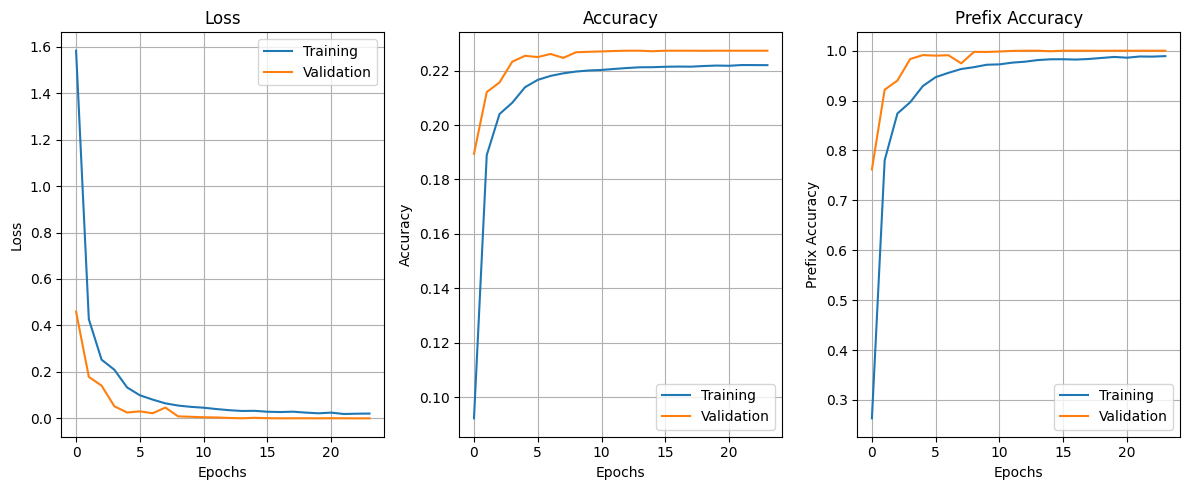

In [ ]:
fig, axes = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(12)


# Loss plot
ax = axes[0]
ax.set_title('Loss')
ax.plot(hist.history['loss'], label='Training')
ax.plot(hist.history['val_loss'], label='Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.grid()

# Accuracy plot
ax = axes[1]
ax.set_title('Accuracy')
ax.plot(hist.history['accuracy'], label='Training')
ax.plot(hist.history['val_accuracy'], label='Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid()

# Prefix accuracy plot
ax = axes[2]
ax.set_title('Prefix Accuracy')
ax.plot(hist.history['prefix_accuracy'], label='Training')
ax.plot(hist.history['val_prefix_accuracy'], label='Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Prefix Accuracy')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

As we can see in the plots, there seems to be no sign of overfitting or underfitting, since both the training and the validation losses/metrics improve with increasing epochs. Actually, validation seems to do even better than training.

The standard accuracy metric reaches a low value, but this does not mean that the predictions made by the model will be wrong: this is because the standard accuracy metric checks if the prediction is exactly equal to the ground truth, but in our case we have to consider the presence of padding tokens (that should be ignored). The prefix accuracy is the most accurate metric for our task.

### Evaluating the model

In [ ]:
# Code for loading the weights saved in the public folder
# transformer.load_weights('modelweights.weights.h5')

To perform an evaluation of the model, we have to define an autoregressive decoding loop, meaning a loop in which we define one token at a time and we give the result to the model as the input of the decoder. We implement a Greedy decoding strategy, meaning that the chosen token is the one that has the highest probability.

In [ ]:
def autoregressive_decode(model, encoder_input, sos_id=SOS_ID, eos_id=EOS_ID, max_len=MAX_LEN):
    #first decoder input is the SOS token
    decoder_input =  tf.constant([[sos_id]], dtype=tf.int32)

    for _ in range(max_len):
        # we get the logits from the model (no last Softmax layer)
        logits = model((encoder_input, decoder_input), training=False)
        # we do Greedy decoding to get the new token
        new_token = tf.argmax(logits[:,-1,:], axis=-1, output_type=tf.int32)
        # we save the new token
        decoder_input = tf.concat([decoder_input, tf.expand_dims(new_token, axis=1)], axis=1)
        # if the predicted token was the EOS token, stop the prediction loop
        if tf.equal(new_token[0], eos_id): break

    decoder_output = decoder_input[0].numpy()
    return decoder_output

We use the provided metric to evaluate the model.

In [ ]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

In [ ]:
def test(model,no=20,rounds=10):
  rscores =[]
  for i in range(rounds):
    print("round=",i)
    X_test, Y_test = generate_dataset(no)
    scores = []

    for j in range(no):
      encoder_input=X_test[j]
      generated = autoregressive_decode(model, encoder_input)[1:] #remove SOS
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token, verbose=False))
    rscores.append(np.mean(scores))
  return np.mean(rscores),np.std(rscores)

In [ ]:
res, std = test(transformer)
print("score=",res,"std=",std)

round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
score= 0.9996666666666666 std= 0.0009999999999999898


### Conclusions

The model seems to have an optimal performance. To expand this work, we could also define a Decoder-only architecture and compare it with this model to see if the performance is similar and/or there are some benefits (like a reduced training time for example). We could also compare the model to LSTM Networks or GRUs to see if the Transformer architecture can be effectively considered the state-of-art for infix-to-postfix translation.\
Also, to further evaluate the model, we could also experiment with deeper sequences and see if the results compare with these ones.

### Sources

- https://www.tensorflow.org/text/tutorials/transformer
- https://arxiv.org/pdf/1706.03762
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention